### Benchmark de rerankers / tailles de fragment (chunk size)
**Problème:**<br>
Les retrievers ont du mal à sélectionner les documents pertinents pour des questions complexes, non formulées avec suffisament de détails, et dont le contexte nécessaire pour produire une réponse s'étale sur plusieurs pages<br>

**Cas d'étude:**<br>
Basé sur le PP Mahakam project, AAP dépot sur site<br>
La question n°5 <i>"Context, environment, project rationale and challenges"</i> recouvre des enjeux institutionnels, socio-économiques, de biodiversité ... qui sont impossibles à déduire de façon automatique de la question de départ telle que présentée ci dessus<br>

**Objectifs:**<br>
La question ci-dessus trouve ses réponses sur les pages 9 à 18<br>
Nous allons tenter d'élargir la plage de sélection des documents à 30, puis les analyser avec différentes approches de reranking afin de voir quelle proportion de bonnes pages nous pouvons atteindre sur la première moitiée de la liste (15 premiers documents)

**Méthode:**
1. Créer différentes bases de documents avec des tailles de fragments allant de 500 à 6000 caractères 
2. Créer des retrievers basés sur de la recherche sémantique (mmr), par fréquence de mots (tfidf) et par lexique
3. Extraire les fragments les plus pertinents avec les méthodes natives des retrievers
4. Evaluer ces documents avec 4 types de retrievers par rapport à la question de l'AAP:
    * Le score calculé indique dans quelle mesure le document permet de répondre à cette question


### Librairies

In [16]:
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain pypdf

Variables d'nvironement 

In [1]:
import dotenv

dotenv.load_dotenv("/home/chougar/Documents/GitHub/Formation_datascientest/DL-NLP/.env")

True

In [2]:
# libraries and models setup
import os
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma, FAISS
from langchain.retrievers import SelfQueryRetriever
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_ollama.llms import OllamaLLM
from time import time as timing


In [4]:
# model_qa_name="qwen2.5:3b"
# model_qa_name="mistral:latest"
# model_qa_name="deepseek-r1:8b"
#model_qa_name="hf.co/bartowski/Falcon3-7B-Instruct-GGUF:Q4_0"
# model_qa_alias="falcon3-7b-mamba"
# llm_qa = OllamaLLM(model=model_qa_name, temperature=0.2)

model_qa_name="gpt-4o-mini"
model_qa_alias=model_qa_name
llm_qa = ChatOpenAI(model_name=model_qa_name, temperature=0.2)



# Embeddings model definition
# model_emb_name='text-embedding-ada-002'
model_emb_name="text-embedding-3-small"
embedding_model = OpenAIEmbeddings(model=model_emb_name)


#### Step 1: charger le PP

In [7]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

# Load the PDF
pdf_file_path = './data/PROJECT DOCUMENT MAHAKAM 2023-2025_balise.pdf'
loader = PyPDFLoader(pdf_file_path)
pages = loader.load()

# nettoyage
bruits=["Planète Urgence | FOREST Programme"]
for doc in pages:
    for bruit in bruits:
        if bruit in doc.page_content:
            doc.page_content=doc.page_content.replace(bruit, "")
# del empty docs
pages = [doc for doc in pages if len(doc.page_content)>0]

# Combine all pages into a single text blob while tracking page numbers
full_text = ""
page_mapping = []  # Maps each character in `full_text` to its page number
for page in pages:
    page_content = page.page_content
    full_text += page_content + " "  # Add a space between pages
    page_mapping.extend([page.metadata['page']] * len(page_content))  # Map characters to page number
    page_mapping.extend([None] * 1)  # Add a space between pages (optional)


In [8]:
def split_raw_text(chunk_size, full_text=full_text):
    # Use RecursiveCharacterTextSplitter to split the text
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,  # Desired chunk size
        chunk_overlap=chunk_size*0.2,  # Overlap between chunks
        length_function=len,  # Function to measure chunk size
    )

    # Split the text into chunks
    text_chunks = text_splitter.split_text(full_text)

    # Create new Document objects for each chunk with precise page numbers
    chunked_documents = []
    start_idx = 0
    for chunk in text_chunks:
        end_idx = start_idx + len(chunk)
        
        # Get the page numbers for this chunk
        chunk_pages = set(page_mapping[int(start_idx):int(end_idx)])  # Use set to get unique page numbers
        chunk_pages.discard(None)  # Remove None values (spaces between pages)
        
        # Create a new Document object with the chunk and metadata
        new_doc = Document(
            page_content=chunk,
            metadata={
                "source": pdf_file_path,
                "pages": sorted(chunk_pages),  # List of pages contributing to this chunk
            },
        )
        chunked_documents.append(new_doc)
        
        # Update the start index for the next chunk
        start_idx = end_idx - text_splitter._chunk_overlap  # Account for overlap
    
    return chunked_documents

#### Step 2: Retrait documents pertinents (phase RETRIEVAL)
Tester plusieurs longueurs de chunks pour voir si la taille améliorer le retrait
1. Creation de n DB selon différentes tailles de chunk

In [ ]:
chunk_sizes=[500, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

In [10]:
databases=[]
for chunk_size in chunk_sizes:
    
    split_docs = split_raw_text(chunk_size)
    db=FAISS.from_documents(split_docs, embedding_model,)
    databases.append({"chunk_size": chunk_size, "split_docs": split_docs, "db": db})

In [11]:
for db in databases:
    print(f"chuck {db['chunk_size']}")
    print(len(db['split_docs']))

chuck 500
253
chuck 1000
123
chuck 1500
82
chuck 2000
62
chuck 3000
41
chuck 4000
31
chuck 5000
25
chuck 6000
21


Query rewriter

In [12]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

"v1"
# system = """You are a question re-writer that converts an input question to a better version that is optimized \n
#      for vectorstore retrieval. Re-write the input in an interrogative, clear and concise way."""

"v2"
# system="""
#     You are a **question rewriter** that refines input questions to optimize them for **vector store retrieval**.  

#     ### **Instructions:**  
#     - Convert the input into a **clear, concise, and well-structured interrogative sentence**.  
#     - Ensure the reworded question **preserves the original intent** while improving retrieval effectiveness.  
#     - Remove ambiguity and redundant phrasing to enhance search relevance.  

#     Here is the initial question: \n\n {question} \n Formulate an improved question.

#     ### **Optimized Output:**  
#     Provide only the rewritten question, without any additional text.  

# """

"v3"
system="""
    You are a question rewriter tasked with improving input questions to optimize them for vector store retrieval. 
    Your mission is to refine, rephrase, and enhance the provided questions to ensure they are:
    * Clear and easy to understand.
    * Focused.
    * Optimized for effective retrieval by removing ambiguities.
    * Written in an interrogative form while preserving the original intent.

    #### Input Fields to Rework:
    Example 1:
    * Project Description: Reword questions that focus on the project’s overall scope and objectives.
    Example 2:
    * Country and City: Refine questions to specifically inquire about the project’s location.
    Example 3:
    * Target Beneficiaries: Enhance questions to clarify the population or group that benefits from the project.    
    * Number of People Concerned: Rework questions to quantify how many people the project impacts.
    Example 4:
    * Context, Environment, Project Rationale, Challenges, include these topics to enhance the final output:
            * Environmental Context
            * Biodiversity
            * Climate Change impacts
            * Socio-Economic Context
            * Economic, Demographic, Community impacts
            * Institutional context
            * Health context
        Rephrase questions that ask for background information, challenges, and the reasoning behind the project.

    Example 5:
    * Project Start Date / End Date: Rework questions regarding the project’s timeline.
    Example 6:
    * Financial Information:
        * Project Budget: Reword questions about the overall project budget.
        * Total Project Cost: Rephrase inquiries about the total cost of the project.
        * Donation Request Amount: Refine questions asking about the amount of funding requested.
        * Provisional Project Budget: Rework questions about the detailed provisional budget for the project.
        * Current Year Budget: Enhance questions related to the budget specific to the current year.


    #### Response Format:
    For each input question, rephrase it in a clear, and interrogative form, optimized for vector store retrieval. Return only the reworked question.
"""

"v4"
# system = """
#     You are a question rewriter tasked with improving input questions to optimize them for vector store retrieval. 
#     Your mission is to refine, rephrase, and enhance the provided questions to ensure they are:
#     * Clear and easy to understand.
#     * Focused.
#     * Optimized for effective retrieval by removing ambiguities.
#     * Written in an interrogative form while preserving the original intent.
#     * **Expanded with relevant details when applicable** (e.g., including specific topics related to the question).  

#     #### Input Fields to Rework:
#     Example 1:
#     * Project Description: Reword questions that focus on the project’s overall scope and objectives.
#     Example 2:
#     * Country and City: Refine questions to specifically inquire about the project’s location.
#     Example 3:
#     * Target Beneficiaries: Enhance questions to clarify the population or group that benefits from the project.    
#     * Number of People Concerned: Rework questions to quantify how many people the project impacts.
#     Example 4:
#     * Context, Environment, Project Rationale, Challenges: When reformulating questions related to this category, **explicitly incorporate** relevant aspects, such as:
#         - Environmental Context
#         - Biodiversity
#         - Climate Change Impacts
#         - Socio-Economic Context
#         - Economic, Demographic, and Community Impacts
#         - Institutional Context
#         - Health Context  

#     *Ensure that reformulated questions include these aspects where relevant.*

#     Example 5:
#     * Project Start Date / End Date: Rework questions regarding the project’s timeline.
#     Example 6:
#     * Financial Information:
#         * Project Budget: Reword questions about the overall project budget.
#         * Total Project Cost: Rephrase inquiries about the total cost of the project.
#         * Donation Request Amount: Refine questions asking about the amount of funding requested.
#         * Provisional Project Budget: Rework questions about the detailed provisional budget for the project.
#         * Current Year Budget: Enhance questions related to the budget specific to the current year.

#     #### Response Format:
#     For each input question, rephrase it in a **clear, interrogative form** optimized for vector store retrieval.  
#     *If the question relates to a category with specific example topics, explicitly integrate those topics into the reworded question.*  
#     Return **only the reworked question**.
# """

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
llm_rewriter = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.2)
question_rewriter = re_write_prompt | llm_rewriter | StrOutputParser()
# question="""Context, environment, project rationale and challenges"""
question="Country and City"
# question="Number of people concerned"
# question="Description of the project"
print(f"Initial question:\n{question}")
question_rewriter.invoke({"question": question})

Initial question:
Country and City


'What is the specific country and city where the project is located?'

#### Step 3: Creation des rerankers

In [13]:
from sentence_transformers import CrossEncoder
from transformers import pipeline
import torch
from sentence_transformers import SentenceTransformer


reranker1 = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
# Load the reranker model in bfloat16 precision
reranker2 = pipeline(
    "text-classification", 
    model="BAAI/bge-reranker-v2-m3", 
    device=-1,  # Use GPU
    # torch_dtype=torch.flo  # Load in bfloat16 precision
)



reranker3 = SentenceTransformer("Alibaba-NLP/gte-multilingual-reranker-base", trust_remote_code=True, device='cpu')



/home/chougar/miniconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2025-03-10 14:30:28.738995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741613428.763620   20571 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741613428.771201   20571 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Device set to use cpu
No sentence-transformers model found with name Alibaba-NLP/gte-multilingual-reranker-base. Creating a new one with

In [ ]:
reranker4 = pipeline(
    "text-classification", 
    model="BAAI/bge-reranker-v2-gemma", 
    device=0,  
    torch_dtype=torch.bfloat16 
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-reranker-v2-gemma and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [196]:
### Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Score for relevance check on retrieved documents."""

    score: int = Field(
        description="Documents are relevant to the question, score from 1 (not relevant) to 10 (perfectly relevant)"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a score from 1 (not relevant) to 10 (perfectly relevant) to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

reranker5 = grade_prompt | structured_llm_grader
question = "What is the specific country and city where the project is being implemented?"
doc_txt = """
The location of the project is in Paser District (Adang Bay village) and Kutai
            Kartanegara district (Delta Mahakam) East Kalimantan Province. The location
            of project is nearby the new capital of Indonesia which is in the Penajam
            Paser Utara (around 130-160 km)
"""
eval=reranker5.invoke({"question": question, "document": doc_txt}).score
print(eval)


8


Tester les rerankers sur un exemple simple

In [197]:
query = "What is the capital of France?"
documents = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "London is the capital of the United Kingdom."
]

rerankers=[
    {"type": "crossencoder", "name": "ms-marco-MiniLM", "instance": reranker1},
    {"type": "pipeline", "name": "bge-reranker-v2-m3", "instance": reranker2},
    {"type": "sentence_transformer", "name": "gte-multilingual-reranker-base", "instance": reranker3},
    {"type": "pipeline", "name": "bge-reranker-v2-gemma", "instance": reranker4},
    {"type": "llm", "name": "gpt4o-mini", "instance": reranker5},
]




# Rerank documents based on the query
def rank_documents(documents, query, rerankers=rerankers):
    from langchain.schema import Document

    ranking_results=[]
    doc_num=1
    for doc in documents:
        if type(doc)==Document:
            content=doc.page_content
        elif type(doc)==str:
            content=doc

        for reranker in rerankers:
            if reranker["type"]=="crossencoder":
                score=reranker["instance"].predict((query, content))
            elif reranker["type"]=="pipeline":
                score=reranker["instance"]([query, content])[1]["score"]
            elif reranker["type"]=="sentence_transformer":
                embeddings=reranker["instance"].encode([query, content])
                score= reranker["instance"].similarity(embeddings[0], embeddings[1]).flatten().tolist()[0]
            elif reranker["type"]=="llm":
                score= reranker["instance"].invoke({"question": query, "document": doc}).score

            ranking_results.append({
                "doc_#": doc_num, "doc": doc, "score": score, "reranker_type": reranker["type"], 
                "reranker_name": reranker["name"],
            })
        doc_num+=1
                
    return ranking_results


In [198]:
import pandas as pd
ranking_results=rank_documents(documents, query)
pd.DataFrame(ranking_results)

,doc_#,doc,score,reranker_type,reranker_name
0,1,Paris is the capital of France.,8.500708,crossencoder,ms-marco-MiniLM
1,1,Paris is the capital of France.,0.918915,pipeline,bge-reranker-v2-m3
2,1,Paris is the capital of France.,0.932206,sentence_transformer,gte-multilingual-reranker-base
3,1,Paris is the capital of France.,0.998812,pipeline,bge-reranker-v2-gemma
4,1,Paris is the capital of France.,10.000000,llm,gpt4o-mini
5,2,Berlin is the capital of Germany.,-2.541009,crossencoder,ms-marco-MiniLM
6,2,Berlin is the capital of Germany.,0.726833,pipeline,bge-reranker-v2-m3
7,2,Berlin is the capital of Germany.,0.867957,sentence_transformer,gte-multilingual-reranker-base
8,2,Berlin is the capital of Germany.,0.998633,pipeline,bge-reranker-v2-gemma
9,2,Berlin is the capital of Germany.,1.000000,llm,gpt4o-mini


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


import string

def remove_punctuation(text):
    text_no_punctuation = text.translate(str.maketrans('', '', string.punctuation))
    words = text_no_punctuation.split()
    return words

def keyword_association_retriever(query, top_k=10, documents=split_docs, print_keywords=False):
    query_keywords = llm_extract_keyworks.invoke({"question":query})
    # print(query_keywords)
    query_keywords = remove_punctuation(query_keywords)  # Liste des mots-clés dans la requête
    if print_keywords:
        print(query_keywords)
    results = []


    for doc in documents:
        doc_text = doc.page_content.lower()
        # Compter les cooccurrences des mots-clés dans le document
        keyword_matches = sum(1 for word in query_keywords if word.lower() in doc_text)
        # Pondérer le score par la densité des mots-clés
        try:
            score = keyword_matches / len(doc_text.split())
        except Exception as e:
            print(e)
            score=0

        results.append((doc, score))

    # Trier les résultats par score
    ranked_results = sorted(results, key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in ranked_results[:top_k]]

system_prompt_exact="""Extract the most relevant keywords from the following text to facilitate searching for important documents containing these terms. 
    Only provide the extracted keywords, without additional text or explanations.
"""

system_prompt_synonyms="""Extract the most relevant keywords from the following text to facilitate searching for important documents.  

- For each extracted keyword, also include its closest synonyms.  
- Return all keywords and synonyms in a **single flat list**, without categorization, explanations, or additional text.  
- Ensure the extracted terms are meaningful and relevant to the text's context.  

### **Output Format:**  
A **comma-separated** flat list of keywords and their closest synonyms.  
"""

prompt_extract_keyworks = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_exact),
        ("human", "{question}"),
    ]
)
llm_extract_keyworks = prompt_extract_keyworks | llm_qa | StrOutputParser()
# resp=llm_extract_keyworks.invoke(question)
# remove_punctuation(resp)





['Context', 'environment', 'project', 'rationale', 'challenges']


In [239]:
# Bench des retrievers
from langchain.retrievers import BM25Retriever, TFIDFRetriever
import pandas as pd
import numpy as np


question = "Context, environment, project rationale and challenges"
enhanced_query= question_rewriter.invoke({"question": question})
print(f"Enhanced query: {enhanced_query}")

# récu des pages du pdf associées aux fragments de docs
def get_pages(d):
    return d.metadata["pages"]


# détecter si la page retournée par le retriever est dans la bonne plage de pages pour la question posée
target_pages=np.arange(8, 18)
def in_target(pages):
    for p in pages:
        if p in target_pages:
            return True
        else:
            return False

# stockages des stats de bonne couverture des pages cibles
stats_is_target=[]
global_ranking_results=[]

for i in range(0, len(databases)):
    # get params
    faiss_db=databases[i]["db"]
    split_docs=databases[i]["split_docs"]
    chunk_size=databases[i]["chunk_size"]

    print(f"""Chunk size: {chunk_size}\n""")
    print(f"Nb docs: {len(split_docs)}\n\n")

    # build retievers
    search_type="mmr"
    retriever_faiss = faiss_db.as_retriever(
        search_kwargs={
            "k": 15, 
            "fetch_k": 40
        },
        search_type= search_type
    )

    sparse_retriever_tfidf = TFIDFRetriever.from_documents(
        documents=split_docs,
        k=15,
        tfidf_params={"min_df":1,
                "max_df":2,
                "ngram_range":(1, 2)}
        )



    # get docs
    result_dense = retriever_faiss.invoke(enhanced_query)
    result_dense = [doc.metadata.update({"type": "dense"}) or doc for doc in result_dense]

    result_sparse = sparse_retriever_tfidf.invoke(enhanced_query)
    result_sparse = [doc.metadata.update({"type": "sparse"}) or doc for doc in result_sparse]

    result_lexical= keyword_association_retriever(query=enhanced_query, top_k=10, documents=split_docs, print_keywords=False)
    result_lexical = [doc.metadata.update({"type": "lexical"}) or doc for doc in result_lexical]


    # Fusionner docs
    combined_results = result_dense+result_sparse+result_lexical

    # Supprimer les doublons
    unique_results = {doc.page_content: doc for doc in combined_results}.values()

    print(f"Combined docs: {len(combined_results)}")
    print(f"Unique docs: {len(unique_results)}")

    # ranking des docs
    print("Ranking docs")
    ranking_results=rank_documents(unique_results, enhanced_query)
    global_ranking_results=global_ranking_results+ranking_results

    # ajout chunk_size & pages source
    global_ranking_results=[e.update({"chunk_size":chunk_size, "page":e["doc"].metadata["pages"]}) or e for e in global_ranking_results]
    
    # analyse du ranking
    df_ranking_results= pd.DataFrame(ranking_results)

    # get pages num from metadata
    df_ranking_results["pages"]=df_ranking_results['doc'].apply(get_pages)

    # check if pages are in the list of target pages (8 to 18)
    df_ranking_results["is_target"]= df_ranking_results["pages"].apply(in_target)



    for reranker in df_ranking_results["reranker_name"].unique():
        # filtre sur reranker
        _df_ranking_results= df_ranking_results[df_ranking_results["reranker_name"]==reranker].sort_values("score", ascending=False).reset_index(drop=True)

        # stats first half    
        df_first_half=_df_ranking_results.loc[: int(len(_df_ranking_results)/2)]
        nb_positiv_pages_first_half= df_first_half["is_target"].sum()
        rate_positiv_pages_first_half= df_first_half["is_target"].sum()/len(df_first_half)

        # stats last half
        df_last_half=_df_ranking_results.loc[int(len(_df_ranking_results)/2)+1:]
        nb_positiv_pages_last_half= df_last_half["is_target"].sum()
        rate_positiv_pages_last_half= df_last_half["is_target"].sum()/len(df_last_half)

        stats_is_target.append({
            "chunk_size": chunk_size, "reranker": reranker, "#_docs_in_target": _df_ranking_results["is_target"].sum(),
            "nb_positive_docs_first_half": nb_positiv_pages_first_half,
            "rate_positive_docs_first_half": rate_positiv_pages_first_half,
            "nb_positive_docs_last_half": nb_positiv_pages_last_half,
            "rate_positive_docs_last_half": rate_positiv_pages_last_half    
        })

    print(f"\n------------\n")


Enhanced query: What are the contextual factors, environmental considerations, project rationale, and challenges associated with this project?
Chunk size: 500

Nb docs: 253


Combined docs: 40
Unique docs: 37
Ranking docs

------------

Chunk size: 1000

Nb docs: 123


Combined docs: 40
Unique docs: 33
Ranking docs

------------

Chunk size: 1500

Nb docs: 82


Combined docs: 40
Unique docs: 29
Ranking docs

------------

Chunk size: 2000

Nb docs: 62


Combined docs: 40
Unique docs: 29
Ranking docs

------------

Chunk size: 3000

Nb docs: 41


Combined docs: 40
Unique docs: 28
Ranking docs

------------

Chunk size: 4000

Nb docs: 31


Combined docs: 40
Unique docs: 24
Ranking docs

------------

Chunk size: 5000

Nb docs: 25


Combined docs: 40
Unique docs: 23
Ranking docs

------------

Chunk size: 6000

Nb docs: 21


Combined docs: 40
Unique docs: 21
Ranking docs

------------



In [241]:
df_stats_is_target= pd.DataFrame(stats_is_target)
df_stats_is_target.to_csv("./retrievers-benchmark-stats_is_target.csv", index=False)
df_global_ranking_results=pd.DataFrame(global_ranking_results)
df_global_ranking_results.to_csv("./retrievers-benchmark-global_ranking_results.csv", index=False)

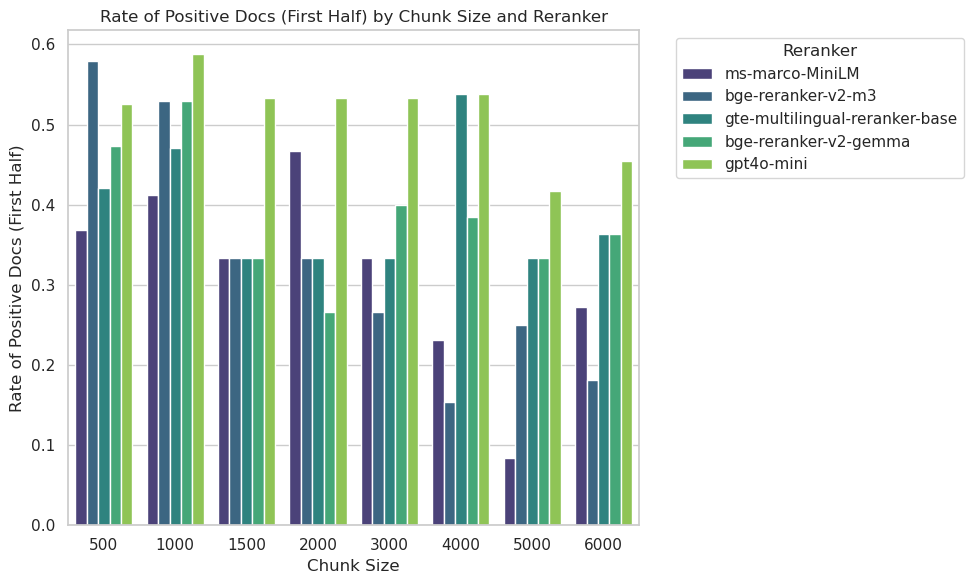

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_stats_is_target.sort_values("rate_positive_docs_first_half", ascending=False).head()


sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    x="chunk_size",
    y="rate_positive_docs_first_half",
    hue="reranker",
    data=df_stats_is_target,
    palette="viridis", 
)

# labels and title
plt.xlabel("Chunk Size")
plt.ylabel("Rate of Positive Docs (First Half)")
plt.title("Rate of Positive Docs (First Half) by Chunk Size and Reranker")

plt.legend(title="Reranker", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### Conclusions:
* Le taux de sélection des bonnes pages (9 à 18), sur les 15 premiers documents, ne dépasse pas 60%
* Le taux de bonne sélection est le plus haut pour la taille de fragment 1000 caractères
* Le seul reranker qui présente des performances consistantes est gpt4 mini
* Hors LLM (gemma et gpt), BGE reranker v2 mini est le meilleur modèle spécialisé (et le plus léger) sur les fragments de 500 et 1000 caractères
* Ce travail ayant été motivé par l'article longRAG n'a pas confirmé ses résultats, affirmant que des documents avec un long contexte, combinés avec des rerankers efficaces, permet d'extraire les fragments les plus pertinents